In [1]:
import numpy as np
import pandas as pd
import pandahouse as ph

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

from CH import Getch
from scipy import stats as ss

In [2]:
# выставляю настройки для отображения графиков
sns.set(font_scale=2, style="whitegrid", rc={'figure.figsize':(20,7)})

In [3]:
# формирую запрос
q = """
SELECT exp_group, 
       user_id,
       countIf(action = 'like') as likes,
       countIf(action = 'view') as views,
       likes/views as ctr
  FROM {db}.feed_actions 
 WHERE toDate(time) between '2024-08-30' and '2024-09-05'
   AND exp_group in (1,2)
 GROUP BY exp_group, user_id
"""

In [4]:
# с помощью класса Getch из модуля CH отправляю запрос и получаю дата-фрейм
df = Getch(q).df
df.tail()

,exp_group,user_id,likes,views,ctr
19892,1,132567,52,326,0.159509
19893,1,30872,11,59,0.186441
19894,2,25383,42,127,0.330709
19895,2,139020,17,41,0.414634
19896,2,17310,9,82,0.109756


In [5]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


группа 1 — контроль, группа 2 — таргет (использовала новый алгоритм рекомендации постов)

Наблюдений достаточно много, и группы почти равнозначны по их количеству

<Axes: xlabel='ctr', ylabel='Count'>

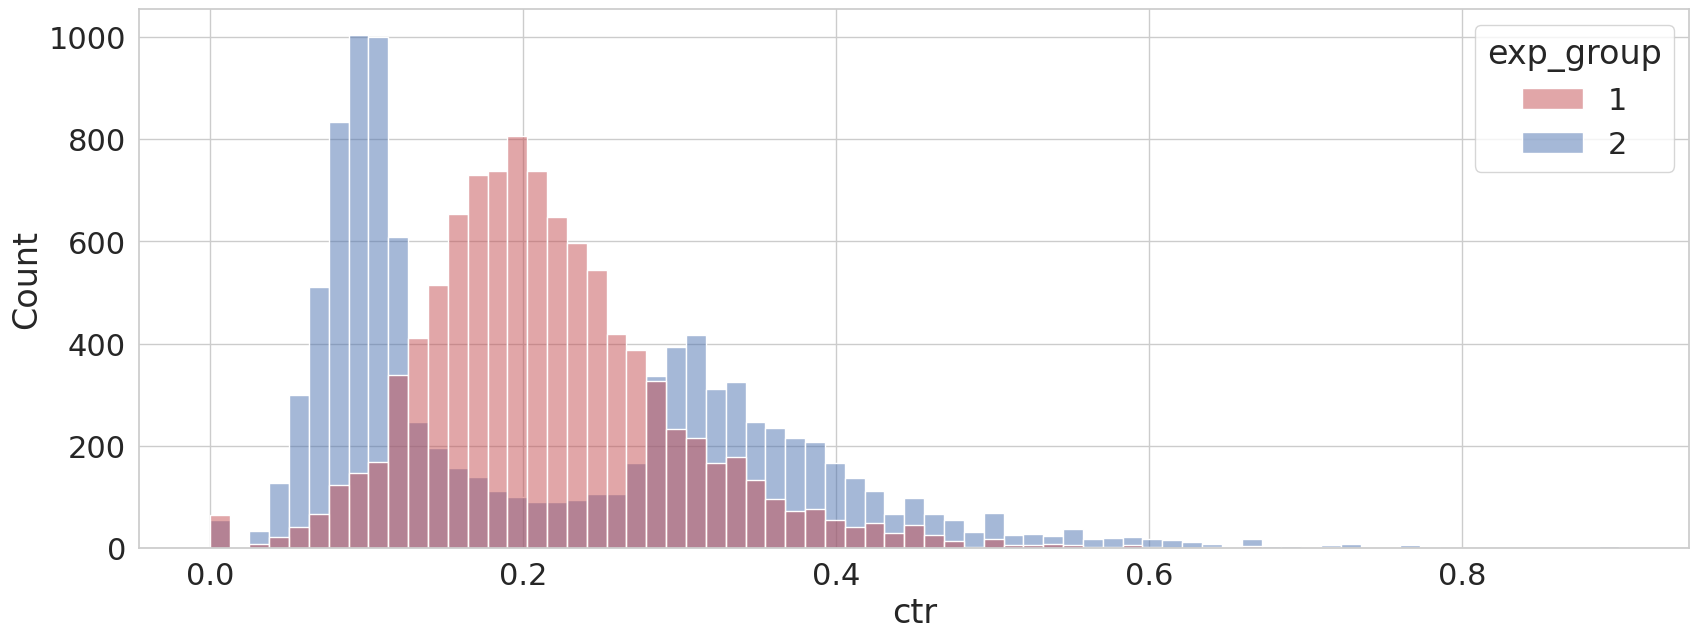

In [6]:
# смотрим формы распределений
sns.histplot(data = df,
            x='ctr', 
            hue='exp_group', 
            palette = ['r', 'b'],
            kde=False)

In [7]:
df[df.exp_group == 1].ctr.mean() < df[df.exp_group == 2].ctr.mean()

False

## t-тест ##

Таргетная группа имеет бимодальное распределение. Это сильно искажает среднее значение, из-за чего t-тест не самый подходящий выбор для сравнения этих двух групп, но всё равно проверим. В итоге t-тест даёт высокое значение p-value (как будто две группы не различаются)

In [8]:
# Welch's t-test
ss.ttest_ind(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

## тест Манна-Уитни ##

тест Манна-Уитни проверяет следующие гипотезы:
- Нулевая гипотеза H0: Вероятность взять из одной группы значение больше случайного значения из второй группы равна вероятности взять случайно из второй группы значение больше случайного значения из первой группы 
- Альтернативная гипотеза H1: Эти вероятности неравны

In [9]:
ss.mannwhitneyu(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Низкое значение p-value в итоге говорит о различиях в двух группах, что позволяет отклонить нулевую гипотезу, следовательно группы различаются

## t-тест на сглаженном ctr (α=5) ##

In [10]:
# функция для вычисления сглаженного ctr
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha=5):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [11]:
# вычисляем глобальный ctr
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [12]:
# вычисляем сглаженный ctr
df['smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1), axis=1)
df['smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1), axis=1)

In [13]:
df.tail()

,exp_group,user_id,likes,views,ctr,smoothed_ctr
19892,1,132567,52,326,0.159509,0.160266
19893,1,30872,11,59,0.186441,0.188250
19894,2,25383,42,127,0.330709,0.326121
19895,2,139020,17,41,0.414634,0.392348
19896,2,17310,9,82,0.109756,0.115494


<Axes: xlabel='smoothed_ctr', ylabel='Count'>

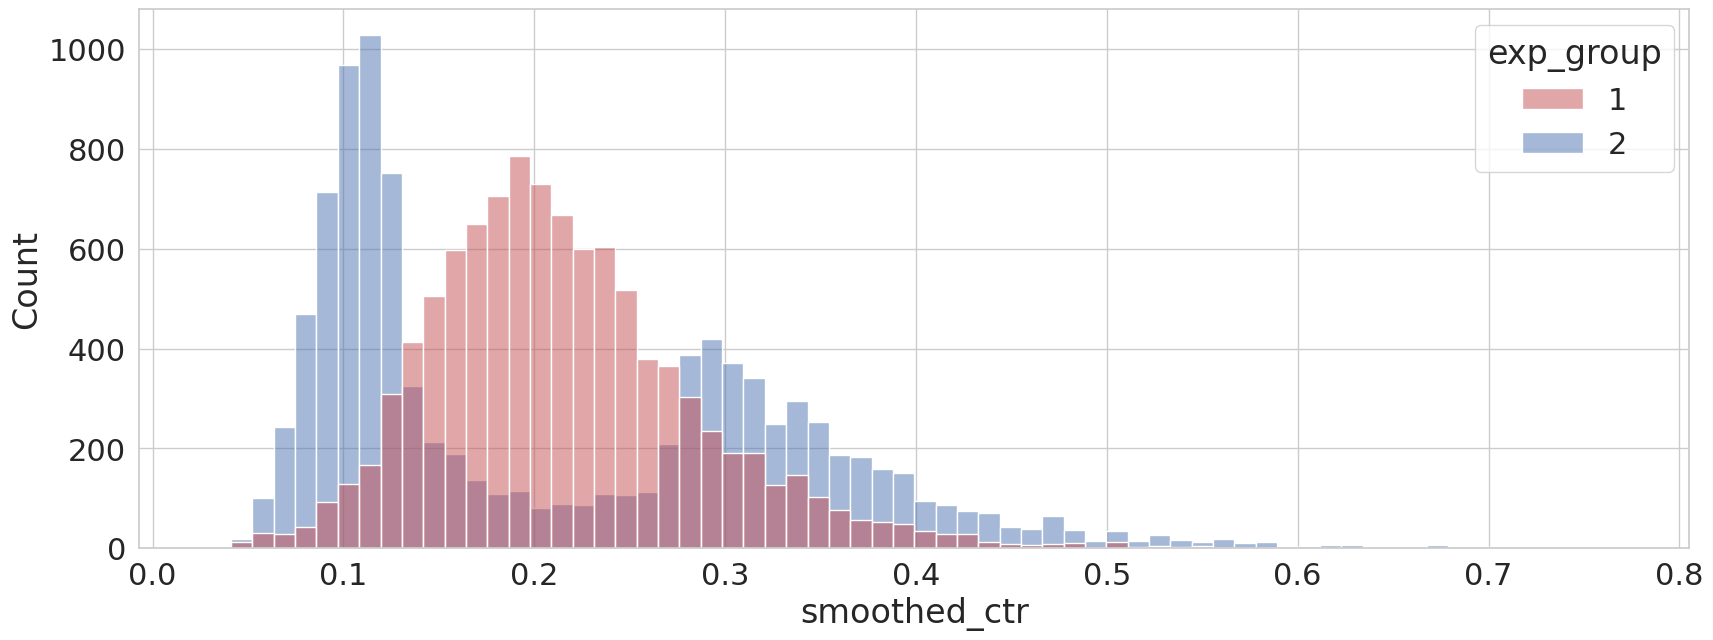

In [14]:
# распредение глобального ctr в группах
sns.histplot(data = df,
            x='smoothed_ctr', 
            hue='exp_group', 
            palette = ['r', 'b'],
            kde=False)

В итоге сглаживание ctr не сильно повлияло на его распределение: в таргетной группе оно так и осталось бимодальным. Применять к нему повторно t-тест не вижу смысла

## Пуассоновский бутстреп ##

In [15]:
# функция для реализации пуассоновского бутстрепа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = ss.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = ss.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<Axes: ylabel='Count'>

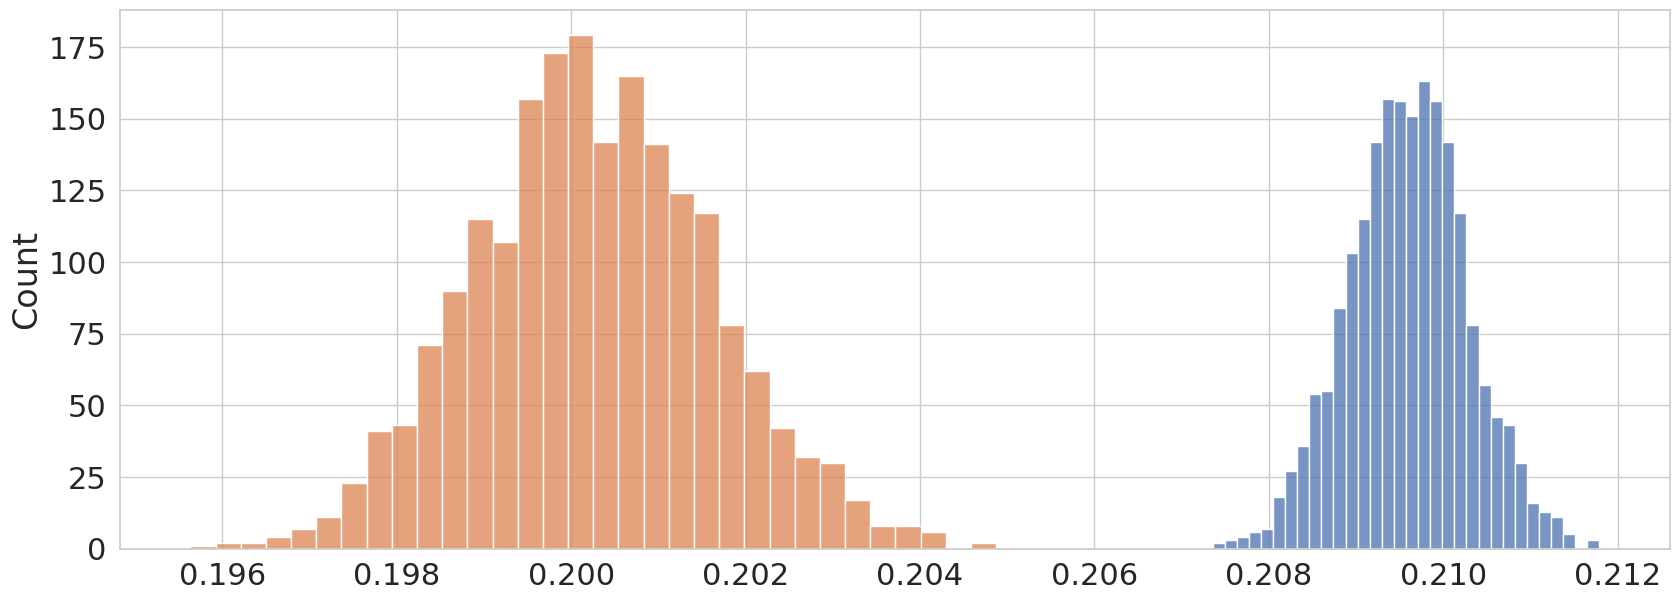

In [16]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

Получаем два распределения значений глобальното ctr по бутстреп-выборкам по двум группам. Видим, что они даже не пересекаются, что говорит о разнице между группами.

<Axes: ylabel='Count'>

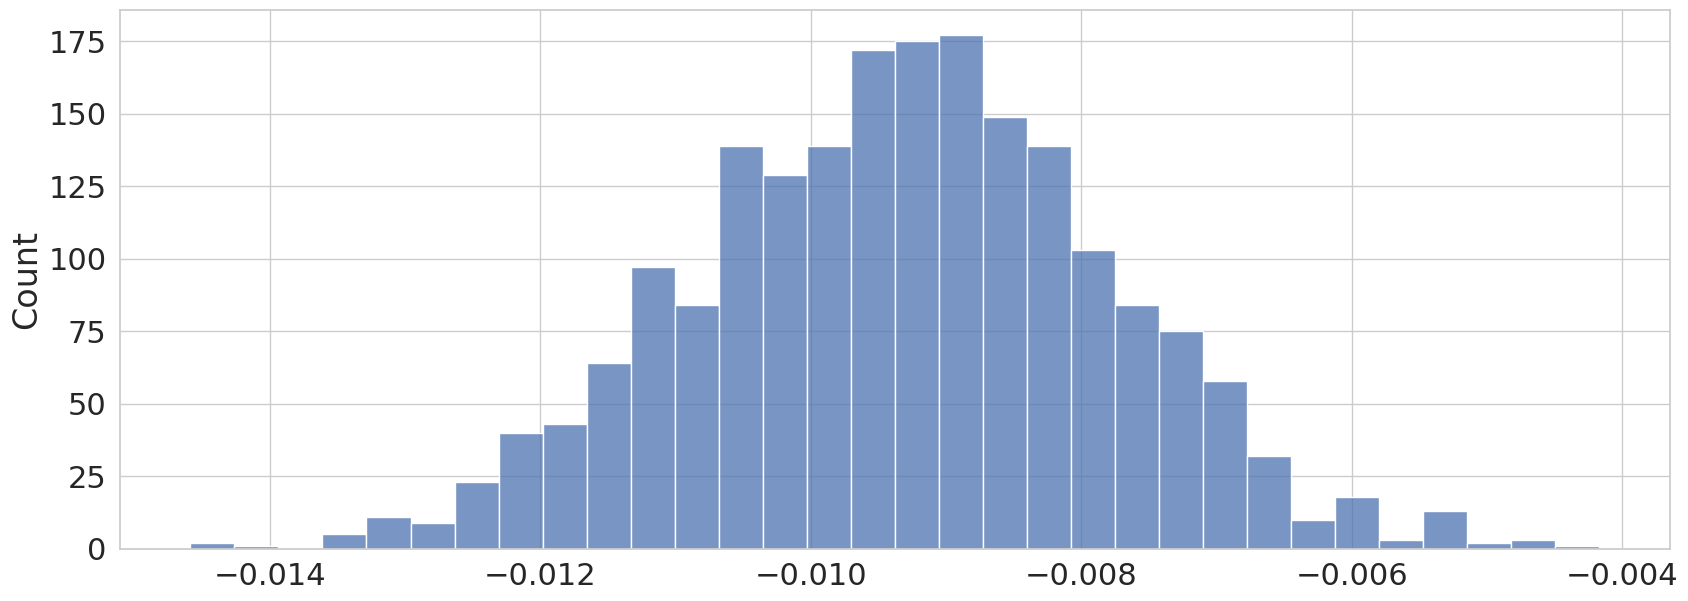

In [17]:
sns.histplot(ctr2 - ctr1)

Глобальный ctr в таргетной группе изменился в отрицательную сторону по сравнению с контрольной, что говорит об отрицальных эффектах новой рекомендательной системы

## t-тест поверх бакетного преобразования ##

In [18]:
# разбиваем пользователей по бакетам и вычисляем побакетный ctr прямо в ClickHouse
q = """
SELECT exp_group, bucket,
       sum(likes)/sum(views) as bucket_ctr
  FROM (SELECT exp_group, 
               xxHash64(user_id)%50 as bucket,
               user_id,
               sum(action = 'like') as likes,
               sum(action = 'view') as views,
               likes/views as ctr
          FROM {db}.feed_actions 
         WHERE toDate(time) between '2024-08-30' and '2024-09-05'
           AND exp_group in (1,2)
         GROUP BY exp_group, bucket, user_id)
 GROUP BY exp_group, bucket
"""

In [19]:
df_buckets = Getch(q).df
df_buckets.tail()

,exp_group,bucket,bucket_ctr
95,2,47,0.196808
96,1,48,0.216369
97,2,48,0.194780
98,1,49,0.206288
99,2,49,0.192512


<Axes: xlabel='bucket_ctr', ylabel='Count'>

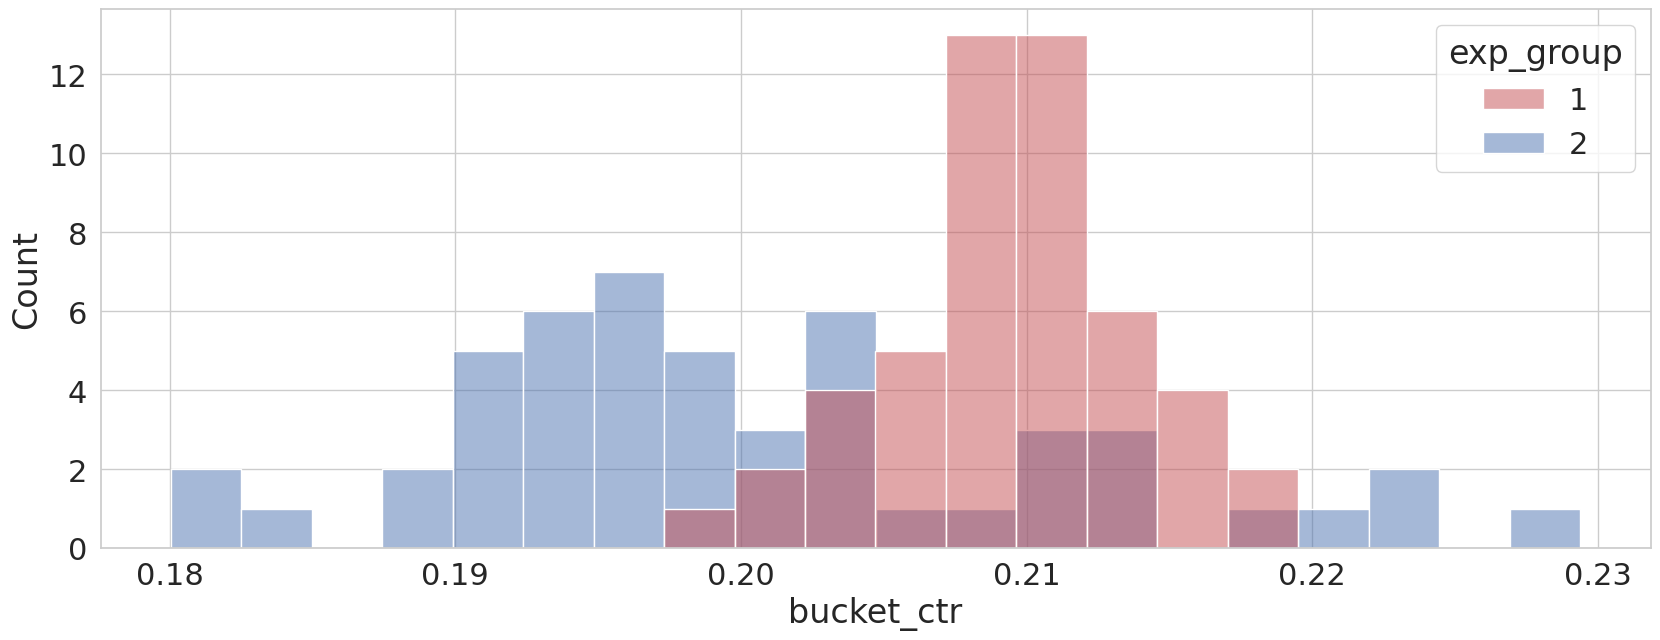

In [20]:
# распредение побакетного ctr
sns.histplot(data = df_buckets,
            x='bucket_ctr', 
            hue='exp_group', 
            palette = ['r', 'b'],
            kde=False,
            bins=20)

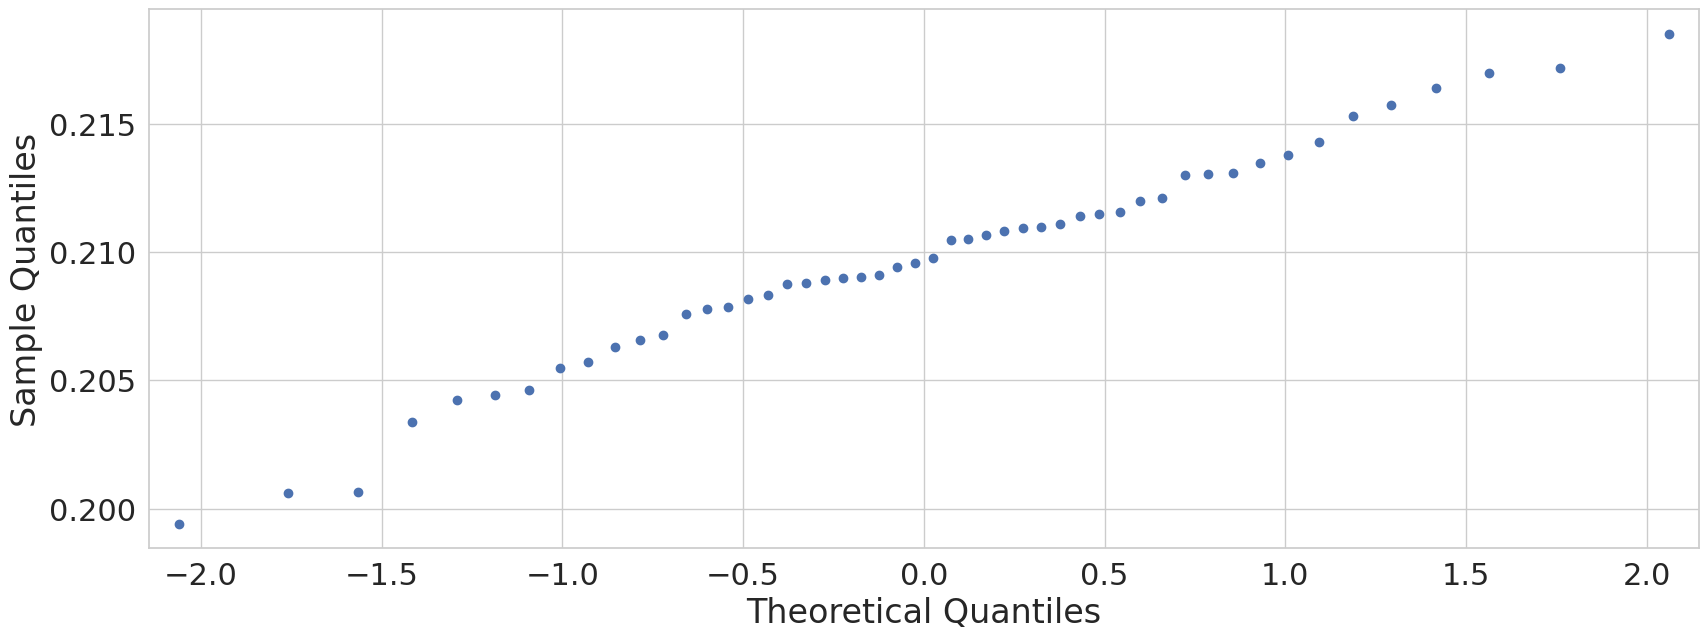

In [21]:
sm.qqplot(df_buckets[df_buckets.exp_group == 1].bucket_ctr)
plt.show()

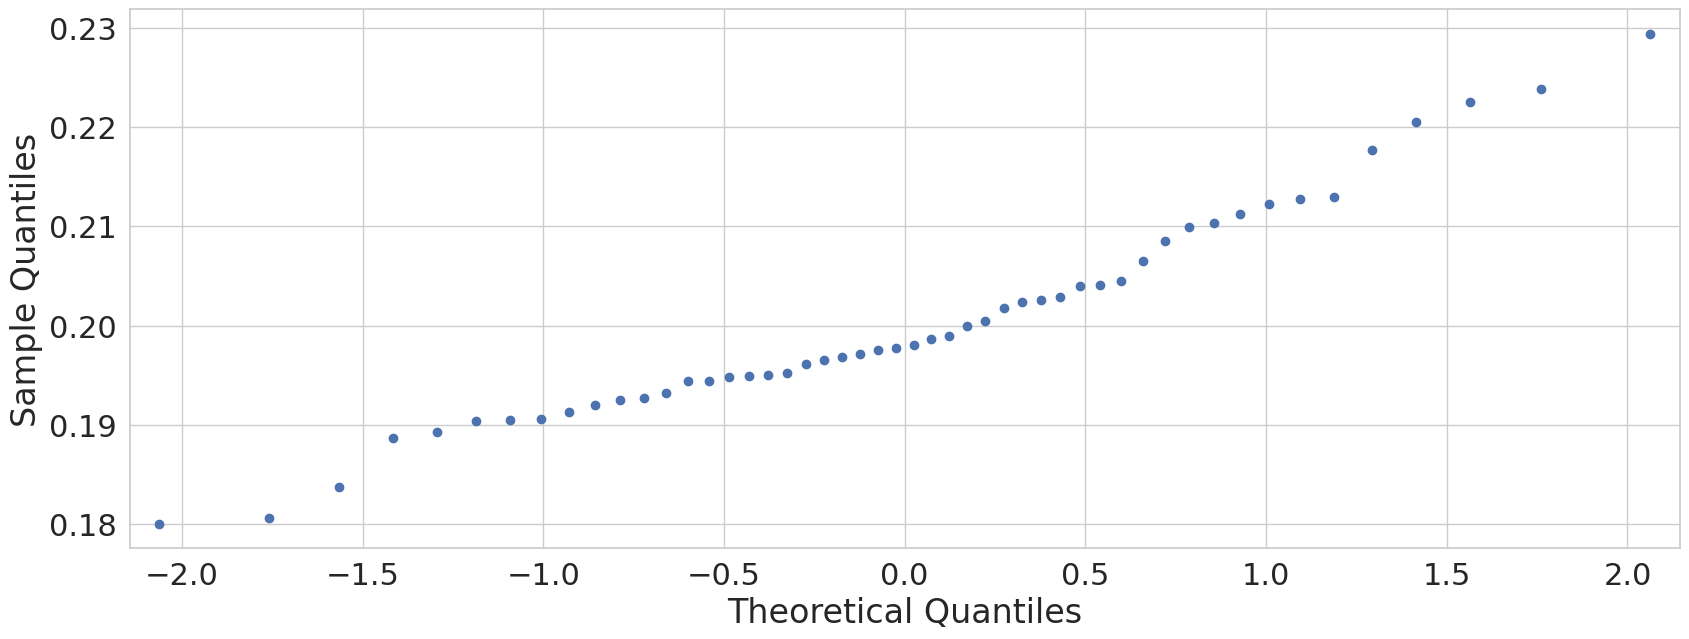

In [22]:
sm.qqplot(df_buckets[df_buckets.exp_group == 2].bucket_ctr)
plt.show()

Проглядывается что-то похожее на нормальное распределение:)

In [23]:
# сравним побакетые ctr с помощью t-теста
ss.ttest_ind(df_buckets[df_buckets.exp_group == 1].bucket_ctr, 
             df_buckets[df_buckets.exp_group == 2].bucket_ctr, 
             equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

Получаем довольно маленький p-value, что даёт возможность отклонить нулевую гипотезу о равенстве средних этих двух групп

<Axes: xlabel='exp_group', ylabel='bucket_ctr'>

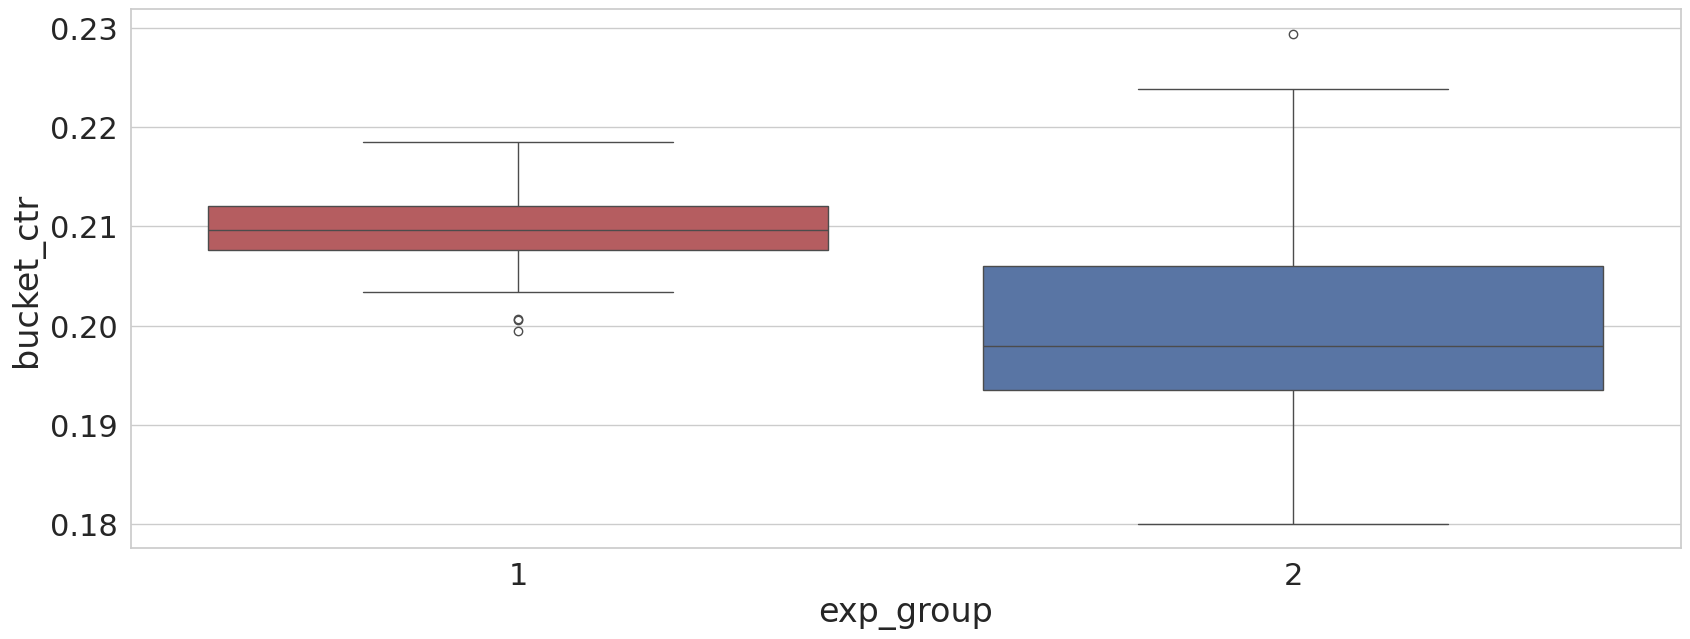

In [24]:
sns.boxplot(data=df_buckets, y='bucket_ctr', x='exp_group', palette = ['r', 'b'])

На графике боксплот тоже видим разницу между группами, у контрольной группы — в положительную сторону. Медианы и межквартильные размахи не пересекаются.

**Вывод: с помощью теста Манна-Уитни, Пуассоновского бутстреп и t-теста поверх бакетного преобразования удалось выявить статистически значимые различия между контрольной и таргетной группами. Показатели CTR в группе с новой системой рекомендаций снизились по сравнению с контрольной группой. Распределение СTR в таргетной группе имеет бимодальную форму, что говорит о разделении пользователей внутри группы на две подгруппы. Возможно на это повлияли какие-то дополнительные факторы (пол, тип операционной системы или же часть данных собиралась в других условиях)**